# **Analyzing "Census Adult Income" Dataset**

# Step 1: Import Libraries, Query dataset, and Explore the Dataset


In [1]:
# Import required libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import warnings
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")


# Initialize BigQuery client (if working with BigQuery)
from google.cloud import bigquery
client = bigquery.Client()

In [2]:
# Corrected query with valid column names
query = """
    SELECT 
        age,
        workclass,
        education,
        marital_status,
        occupation,
        relationship,
        race,
        sex,
        capital_gain,
        capital_loss,
        hours_per_week,
        native_country,
        income_bracket
    FROM `bigquery-public-data.ml_datasets.census_adult_income`
"""
query_job = client.query(query)
# Convert query results into a dictionary
results = query_job.result()  # This fetches all the rows from the query
# Load it directly into a pandas DataFrame
df = pd.DataFrame([dict(row) for row in results])
df.head()


,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,77,Private,9th,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,10,United-States,<=50K
2,38,Private,9th,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,24,Haiti,<=50K
3,28,Private,9th,Married-civ-spouse,Protective-serv,Wife,Black,Female,0,0,40,United-States,<=50K
4,37,Private,9th,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,48,United-States,<=50K


In [3]:
# Check the structure of the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   marital_status  32561 non-null  object
 4   occupation      32561 non-null  object
 5   relationship    32561 non-null  object
 6   race            32561 non-null  object
 7   sex             32561 non-null  object
 8   capital_gain    32561 non-null  int64 
 9   capital_loss    32561 non-null  int64 
 10  hours_per_week  32561 non-null  int64 
 11  native_country  32561 non-null  object
 12  income_bracket  32561 non-null  object
dtypes: int64(4), object(9)
memory usage: 3.2+ MB
None


In [4]:
# Check the structure of the DataFrame
print(df.describe())

                age  capital_gain  capital_loss  hours_per_week
count  32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647   1077.648844     87.303830       40.437456
std       13.640433   7385.292085    402.960219       12.347429
min       17.000000      0.000000      0.000000        1.000000
25%       28.000000      0.000000      0.000000       40.000000
50%       37.000000      0.000000      0.000000       40.000000
75%       48.000000      0.000000      0.000000       45.000000
max       90.000000  99999.000000   4356.000000       99.000000


In [5]:
# Count the number of unique values in each column
unique_counts = df.nunique()

# Print the unique counts for each column
print(unique_counts)

age                73
workclass           9
education          16
marital_status      7
occupation         15
relationship        6
race                5
sex                 2
capital_gain      119
capital_loss       92
hours_per_week     94
native_country     42
income_bracket      2
dtype: int64


# Step 2: Data Cleaning

1. Check the missing values

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
age               0
workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income_bracket    0
dtype: int64


2. Check the duplicates

In [7]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 3465


In [8]:
# Alternatively, if you want to modify the DataFrame in place
df.drop_duplicates(inplace=True)

In [9]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


3. Handling the Data Types

In [10]:
import pandas as pd

# Convert numerical columns explicitly (if necessary)
numerical_columns = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric)

# Convert categorical columns to 'category' type
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation',
                       'relationship', 'race', 'sex', 'native_country', 'income_bracket']
df[categorical_columns] = df[categorical_columns].apply(lambda col: col.astype('category'))

# Verify changes
print("\nUpdated data types:")
print(df.dtypes)



Updated data types:
age                  int64
workclass         category
education         category
marital_status    category
occupation        category
relationship      category
race              category
sex               category
capital_gain         int64
capital_loss         int64
hours_per_week       int64
native_country    category
income_bracket    category
dtype: object


In [11]:
# Check for any anomalies (e.g., unexpected missing or unique values after conversion)
print("\nUnique values in categorical columns:")
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")


Unique values in categorical columns:
workclass: 9 unique values
education: 16 unique values
marital_status: 7 unique values
occupation: 15 unique values
relationship: 6 unique values
race: 5 unique values
sex: 2 unique values
native_country: 42 unique values
income_bracket: 2 unique values


4. Addressing Outliers or Anomalies

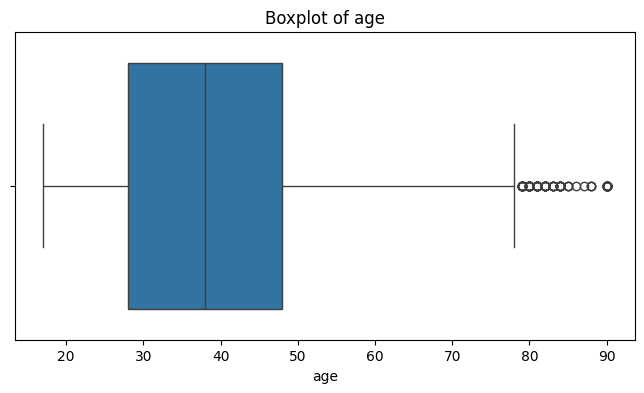

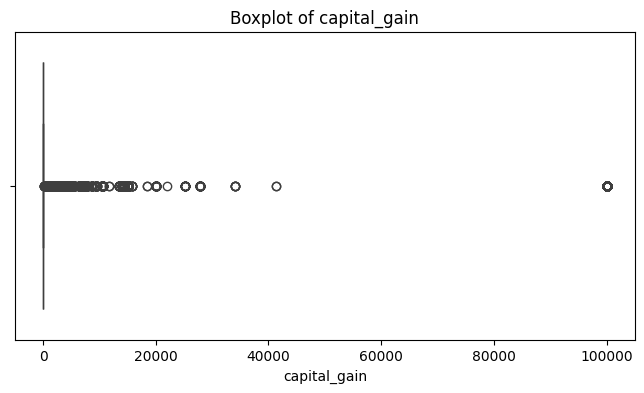

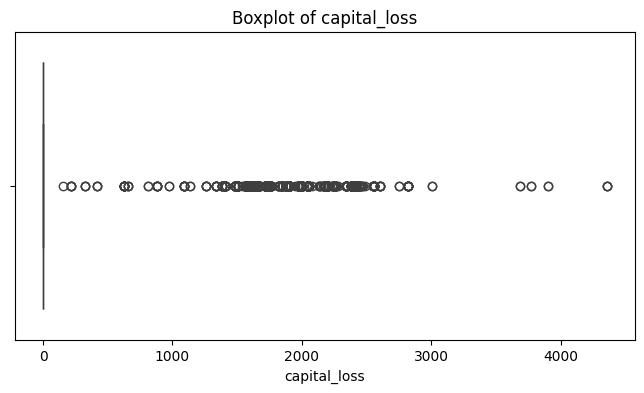

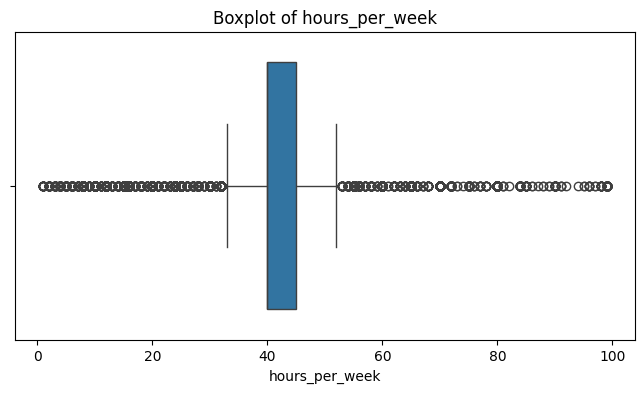

In [12]:
# Visualize potential outliers in numerical columns
numerical_cols = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


## **Why we don't remove the outliers?**
### - **Age**
**Reason:** Extreme ages (young or old) reflect real-world variations in income, such as teenagers or retirees. Removing them would ignore valid demographic trends.<br>
**Decision:** Keep outliers for accurate demographic representation.
### - **Hours Per Week**
**Reason:** Extremely high or low working hours represent diverse work patterns, such as part-time, full-time, or overtime workers. Removing these would discard important data.<br>
**Decision:** Keep outliers to reflect the full spectrum of working hours.

but we deal with the capital_gain and capital_loss as they have an extreme variation

so we use:

## **Winsorization**

 to reduce the impact of extreme values in capital_gain and capital_loss by capping them at a certain percentile. Here, 1% of the highest and lowest values are capped. Adjust the limits parameter to modify this threshold.

In [13]:
from scipy.stats.mstats import winsorize

# Winsorizing capital_gain and capital_loss
df['capital_gain_winsorized'] = winsorize(df['capital_gain'], limits=[0.01, 0.01])
df['capital_loss_winsorized'] = winsorize(df['capital_loss'], limits=[0.01, 0.01])

# Verifying changes
print("Capital Gain - Before and After Winsorization:")
print(df[['capital_gain', 'capital_gain_winsorized']].describe())

print("\nCapital Loss - Before and After Winsorization:")
print(df[['capital_loss', 'capital_loss_winsorized']].describe())

Capital Gain - Before and After Winsorization:
       capital_gain  capital_gain_winsorized
count  29096.000000             29096.000000
mean     704.029317               704.029317
std     2645.844209              2645.844209
min        0.000000                 0.000000
25%        0.000000                 0.000000
50%        0.000000                 0.000000
75%        0.000000                 0.000000
max    15024.000000             15024.000000

Capital Loss - Before and After Winsorization:
       capital_loss  capital_loss_winsorized
count  29096.000000             29096.000000
mean      93.513266                93.513266
std      404.046500               404.046500
min        0.000000                 0.000000
25%        0.000000                 0.000000
50%        0.000000                 0.000000
75%        0.000000                 0.000000
max     2002.000000              2002.000000


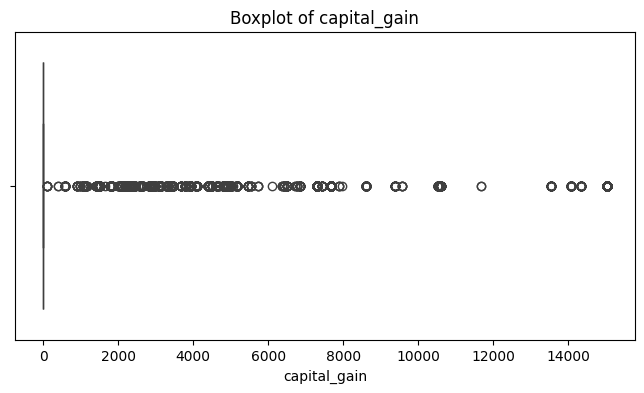

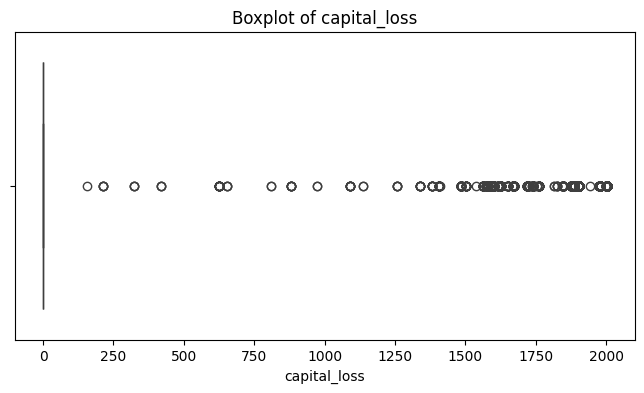

In [14]:
numerical_cols = ['capital_gain', 'capital_loss']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

5. Cleaning Up Invalid or Inconsistent Entries

In [15]:
# Identify unique values in categorical columns
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
for col in categorical_cols:
    print(f"Unique values in {col}:")
    print(df[col].unique())

Unique values in workclass:
[' Private', ' ?', ' Local-gov', ' Self-emp-inc', ' Federal-gov', ' State-gov', ' Self-emp-not-inc', ' Never-worked', ' Without-pay']
Categories (9, object): [' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ..., ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay']
Unique values in education:
[' 9th', ' 10th', ' 11th', ' 12th', ' 1st-4th', ..., ' Doctorate', ' Preschool', ' Assoc-acdm', ' Prof-school', ' Some-college']
Length: 16
Categories (16, object): [' 10th', ' 11th', ' 12th', ' 1st-4th', ..., ' Masters', ' Preschool', ' Prof-school', ' Some-college']
Unique values in marital_status:
[' Married-civ-spouse', ' Separated', ' Never-married', ' Divorced', ' Married-spouse-absent', ' Widowed', ' Married-AF-spouse']
Categories (7, object): [' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed']
Unique values in occupation:
[' Other-service', ' Priv-house-serv', ' Prote

In [16]:
# Correcting variations or typos in 'workclass' category
df['workclass'] = df['workclass'].replace({
    'self-emp-not-inc': 'self-employed',
    'self-emp-inc': 'self-employed'
})

# Standardizing the 'marital_status' categories for consistency
df['marital_status'] = df['marital_status'].replace({
    'married-civ-spouse': 'married',
    'married-spouse-absent': 'married',
    'married-AF-spouse': 'married'
})

df['occupation'] = df['occupation'].replace({
    'machine-op-inspct': 'machine-operation-inspctor',
    'exec-managerial': 'executive',
    'adm-clerical': 'Administrative'
})

df['education'] = df['education'].replace({
    '9th grade': '9th',
    '10th grade': '10th',
    '11th grade': '11th',
    '12th grade': '12th',
    '1st-4th': 'elementary school',
    '5th-6th': 'elementary school',
    '7th-8th': 'middle school',
    'assoc-voc': 'associate\'s degree vocational',
    'assoc-acdm': 'associate\'s degree academic',
    'prof-school': 'professional school',
    'some-college': 'some college'
})


# Checking for unexpected or invalid categories in 'native_country'
df['native_country'] = df['native_country'].replace({'unknown': 'Other'})

# Standardize Text Columns to Lowercase
# Convert other text-based columns to lowercase to avoid inconsistencies.
df['workclass'] = df['workclass'].str.lower()  # Convert 'workclass' to lowercase
df['education'] = df['education'].str.lower()  # Convert 'education' to lowercase
df['marital_status'] = df['marital_status'].str.lower()  # Convert 'marital_status' to lowercase
df['occupation'] = df['occupation'].str.lower()  # Convert 'occupation' to lowercase
df['relationship'] = df['relationship'].str.lower()  # Convert 'relationship' to lowercase
df['race'] = df['race'].str.lower()  # Convert 'race' to lowercase
df['sex'] = df['sex'].str.lower()  # Convert 'sex' to lowercase
df['native_country'] = df['native_country'].str.lower()


# Strip Whitespace from Categorical Columns
# Removing leading/trailing spaces in categorical data to avoid mismatches
df['education'] = df['education'].str.strip()  # Remove extra spaces from 'education'
df['workclass'] = df['workclass'].str.strip()  # Remove extra spaces from 'workclass'
df['marital_status'] = df['marital_status'].str.strip()  # Remove extra spaces from 'marital_status'
df['occupation'] = df['occupation'].str.strip()  # Remove extra spaces from 'occupation'
df['native_country'] = df['native_country'].str.strip()  
df['relationship'] = df['relationship'].str.strip()
df['race'] = df['race'].str.strip()
df['sex'] = df['sex'].str.strip()


# Print a summary of the changes made
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
for col in categorical_cols:
    print(f"Unique values in {col}:")
    print(df[col].unique())



Unique values in workclass:
['private' '?' 'local-gov' 'self-emp-inc' 'federal-gov' 'state-gov'
 'self-emp-not-inc' 'never-worked' 'without-pay']
Unique values in education:
['9th' '10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' 'hs-grad'
 'masters' 'assoc-voc' 'bachelors' 'doctorate' 'preschool' 'assoc-acdm'
 'prof-school' 'some-college']
Unique values in marital_status:
['married-civ-spouse' 'separated' 'never-married' 'divorced'
 'married-spouse-absent' 'widowed' 'married-af-spouse']
Unique values in occupation:
['other-service' 'priv-house-serv' 'protective-serv' 'machine-op-inspct'
 '?' 'tech-support' 'exec-managerial' 'farming-fishing' 'adm-clerical'
 'sales' 'craft-repair' 'transport-moving' 'handlers-cleaners'
 'prof-specialty' 'armed-forces']
Unique values in relationship:
['wife' 'husband' 'own-child' 'unmarried' 'not-in-family' 'other-relative']
Unique values in race:
['black' 'white' 'asian-pac-islander' 'other' 'amer-indian-eskimo']
Unique values in sex:
['female' 'male

In [17]:
# Convert all columns to string type and then check for '?' marks
columns_with_question_mark = df.apply(lambda x: x.astype(str).str.contains('\?', na=False).sum(), axis=0)

# Display columns where '?' appears
print(columns_with_question_mark[columns_with_question_mark > 0])


workclass         1632
occupation        1639
native_country     580
dtype: int64


In [18]:
# Convert '?' to NaN
df['workclass'] = df['workclass'].replace('?', np.nan)
df['occupation'] = df['occupation'].replace('?', np.nan)
df['native_country'] = df['native_country'].replace('?', np.nan)

# Check for NaN values to confirm the conversion
print(df[['workclass', 'occupation', 'native_country']].isna().sum())

workclass         1632
occupation        1639
native_country     580
dtype: int64


In [19]:
# Impute NaN values with the mode (most frequent value) for each column
df['workclass'] = df['workclass'].fillna(df['workclass'].mode()[0])
df['occupation'] = df['occupation'].fillna(df['occupation'].mode()[0])
df['native_country'] = df['native_country'].fillna(df['native_country'].mode()[0])

# Check for NaN values to confirm replacing them
print(df[['workclass', 'occupation', 'native_country']].isna().sum())


workclass         0
occupation        0
native_country    0
dtype: int64


# Step 3: Data Visualization
- Create some charts, colleration matrix, heatmap, and any other additional thing you find by your search 
- Write conclusion under each of the chart

## 1) Pairplot (for numerical features)
- It visualizes the pairwise relationships between numerical features, helping to identify potential correlations or patterns.

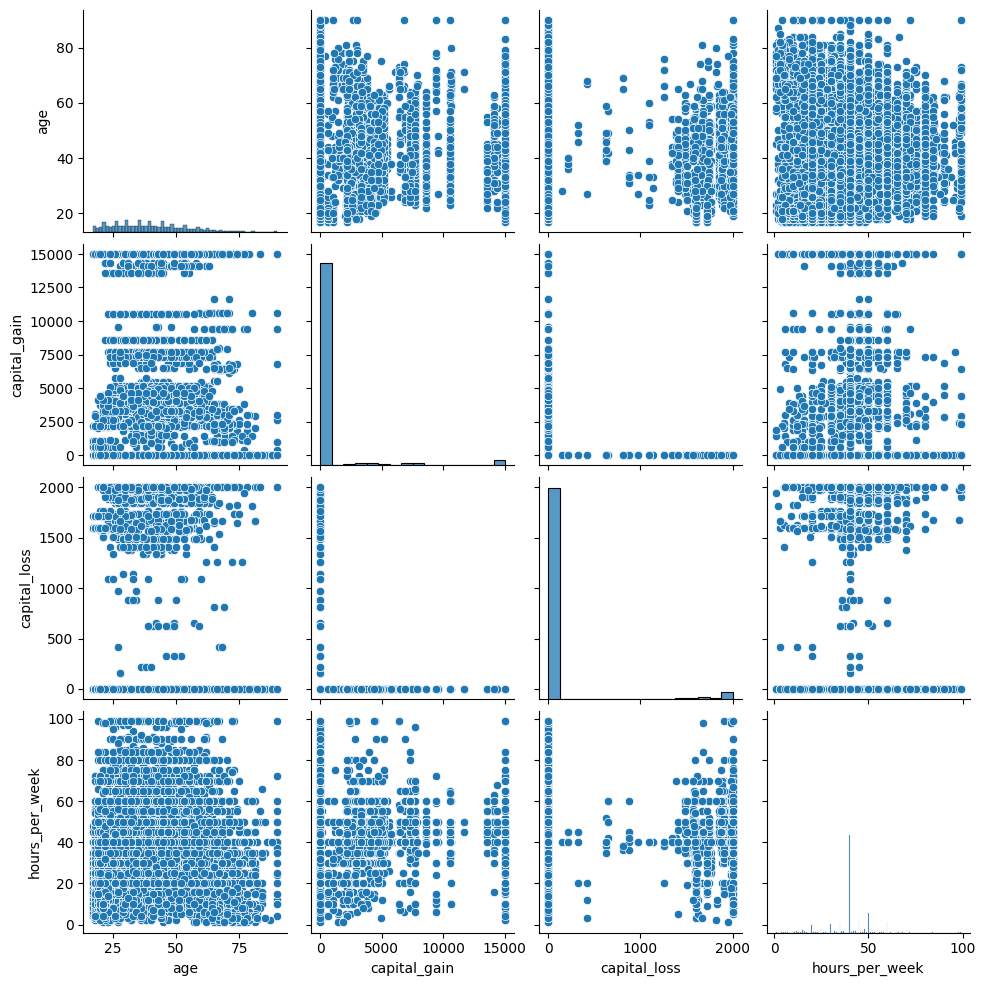

In [20]:
sns.pairplot(df[['age', 'capital_gain', 'capital_loss', 'hours_per_week']])
plt.show()

**Key Findings:**
- There is a relation between "Hours per week of work and Capital gain"
- A potential for relation between "Age and Capital gain"
- A potential for relation "Age and Capital loss"

## 2) Histogram of Age:

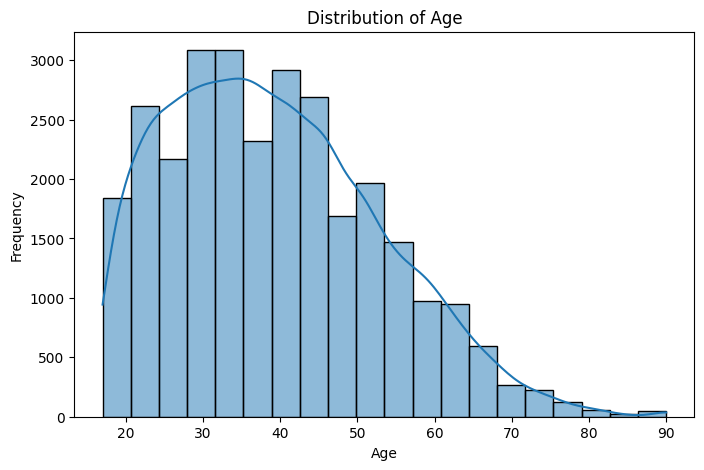

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

**Key Findings:**
- The most frequent age in workforce is ranging from late 20s to mid 30s
- After mid 30s till mid 40s are also common on the workforce 
- People after 60s are rare to continue working

## 3) scatter plot for Age Capital gain & loss:

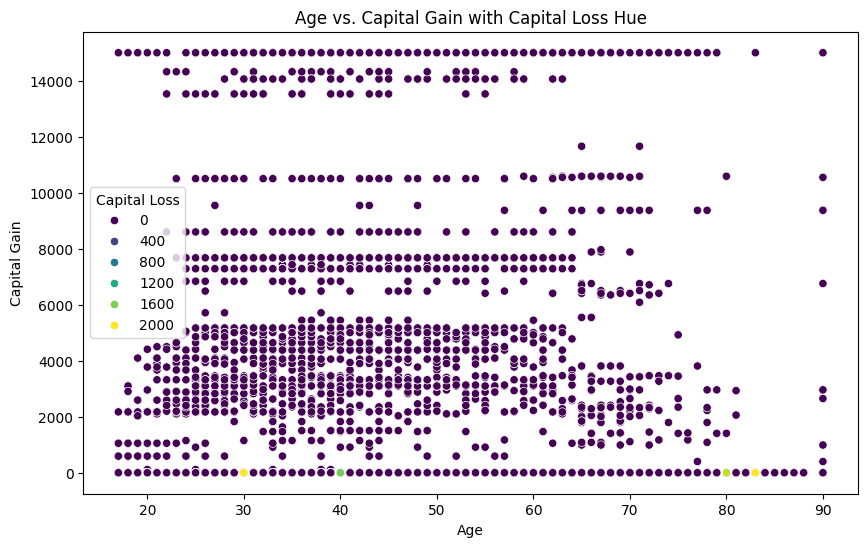

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='capital_gain', hue='capital_loss', data=df, palette='viridis')
plt.title('Age vs. Capital Gain with Capital Loss Hue')
plt.xlabel('Age')
plt.ylabel('Capital Gain')
plt.legend(title='Capital Loss')
plt.show()

**Key findings:**
- No clear relation found

## 4) Boxplot of Hours Per Week by Income Bracket:

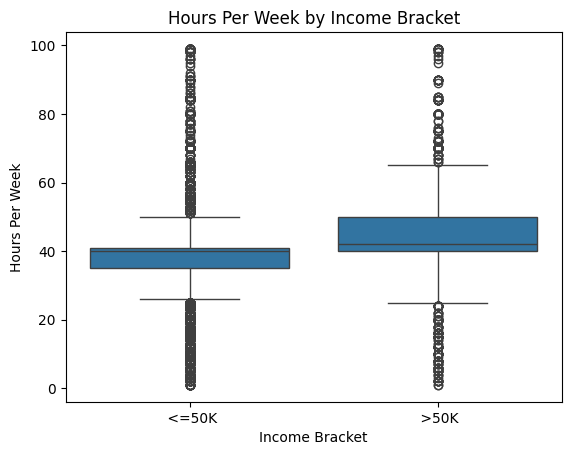

In [23]:
sns.boxplot(x='income_bracket', y='hours_per_week', data=df)
plt.title('Hours Per Week by Income Bracket')
plt.xlabel('Income Bracket')
plt.ylabel('Hours Per Week')
plt.show()

**Key findings:**
- People who work more than 40 hours have an income above 50,000

## 5) Countplot of Income Bracket:

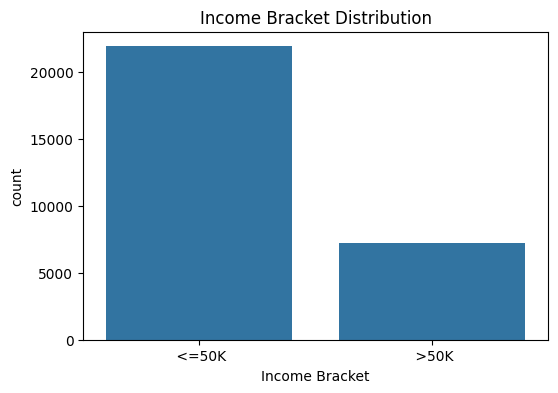

In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(x='income_bracket', data=df)
plt.title('Income Bracket Distribution')
plt.xlabel('Income Bracket')
plt.show()

**Key findings:**
- Most people have income less than 50,000

## 6) Barplot of Education vs. Income Bracket:

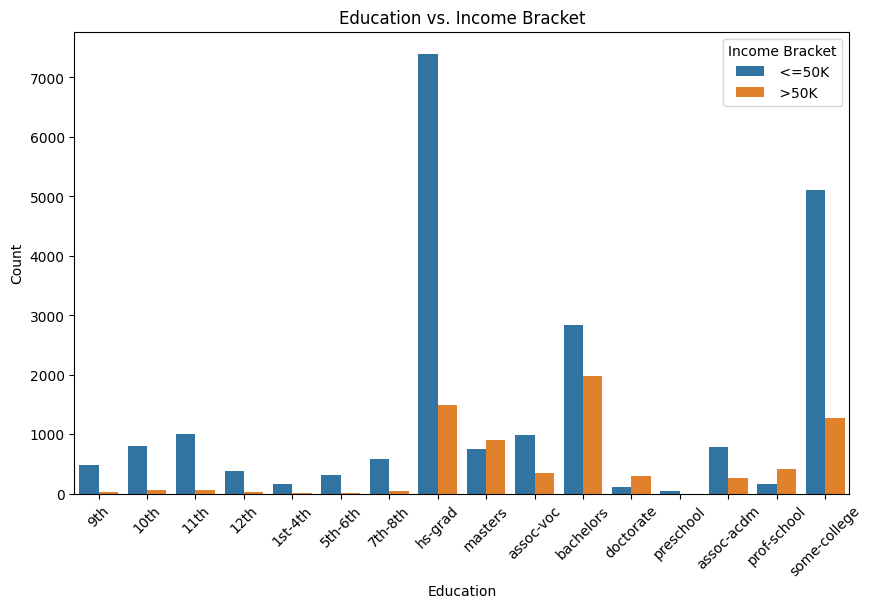

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(x='education', hue='income_bracket', data=df)
plt.title('Education vs. Income Bracket')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Income Bracket')
plt.show()

**Key findings:**
- Most High school grads have income less than 50,000
- It is more common for those who have Bachelor degree to get Income greater than 50,000
- People who hold masters degree are more likley to get more than 50,000
- It could be strongly concluded that obtaining a higher degree could greatly increase the income.

## 7) Correlation Matrix and Heatmap:

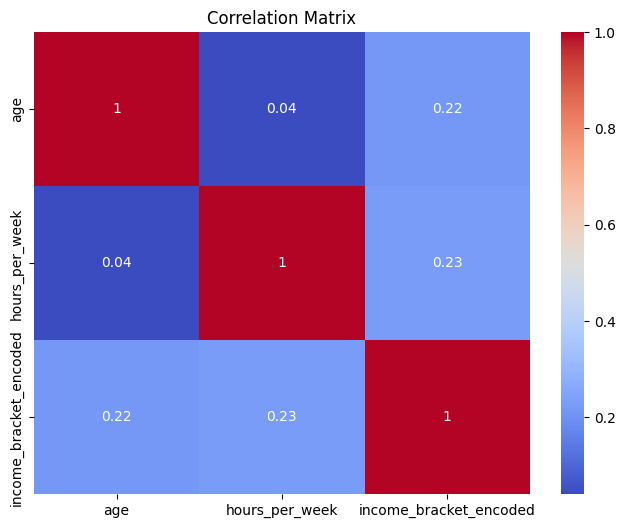

In [26]:
# Encode the income_bracket column to visualize the heatmap
le = LabelEncoder()
df['income_bracket_encoded'] = le.fit_transform(df['income_bracket'])

# Compute correlation matrix
corr_matrix = df[['age', 'hours_per_week', 'income_bracket_encoded']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Key findings:** 
- A weak positive correlation could be found between age and hours per week.

# Step 4: Data Preprocessing

## **1. Feature engineering**

### 1. Combine Features
a. Age Groups
Create age categories to capture potential nonlinear relationships between age and income.

b. Income-to-Hours Ratio
Calculate the ratio of capital_gain to hours_per_week to capture the productivity of capital gain relative to working hours.

c. Combine Marital Status and Relationship
These two features may have overlapping information. Combine them into a single feature to represent the broader context of household structure

### 2. Transform Features
a. Log Transformation
Apply log transformation to capital_gain and capital_loss to reduce skewness in their distribution.

b. Interaction Features
Create interaction terms between important variables (e.g., education and occupation), as these may jointly influence income.

### 3. Drop Less Informative Features
After creating new features, drop redundant or less informative columns, such as:

- The original capital_gain and capital_loss columns after log transformation.
- Redundant categorical columns if combined features are more informative.

In [27]:
# Age groups
bins = [0, 25, 45, 65, 100]
labels = ["Youth", "Adult", "Middle-aged", "Senior"]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

# Capital gain per hour
df["capital_gain_per_hour"] = df["capital_gain"] / (df["hours_per_week"] + 1)

# Combine marital status and relationship
df["marital_relationship"] = df["marital_status"] + "_" + df["relationship"]

# Drop redundant features
df.drop(["capital_gain", "capital_loss"], axis=1, inplace=True)

df.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket,capital_gain_winsorized,capital_loss_winsorized,income_bracket_encoded,age_group,capital_gain_per_hour,marital_relationship
0,39,private,9th,married-civ-spouse,other-service,wife,black,female,34,united-states,<=50K,3411,0,0,Adult,97.457143,married-civ-spouse_wife
1,77,private,9th,married-civ-spouse,priv-house-serv,wife,black,female,10,united-states,<=50K,0,0,0,Senior,0.000000,married-civ-spouse_wife
2,38,private,9th,married-civ-spouse,other-service,wife,black,female,24,haiti,<=50K,0,0,0,Adult,0.000000,married-civ-spouse_wife
3,28,private,9th,married-civ-spouse,protective-serv,wife,black,female,40,united-states,<=50K,0,0,0,Adult,0.000000,married-civ-spouse_wife
4,37,private,9th,married-civ-spouse,machine-op-inspct,wife,black,female,48,united-states,<=50K,0,0,0,Adult,0.000000,married-civ-spouse_wife


## **2. Encoding categorical data**
Since the dataset contains categorical variables (e.g., workclass, education, occupation, etc.), encoding them into numerical format is necessary.

In [28]:
# Identify categorical features
categorical_features=["workclass", "education", "marital_status",
                      "occupation", "relationship", "race",
                      "sex", "native_country", "age_group",
                      "marital_relationship"]

# Identify numerical features
numerical_features=["age", "capital_gain_per_hour",
                    "hours_per_week"]

# Fit and transform categorical features
for column in categorical_features:
    l_encoder=LabelEncoder()
    df[column]=l_encoder.fit_transform(df[column])

# For the target column "Income"
# Ensure there is no leading or trailing whitespace in the column values
df['income_bracket'] = df['income_bracket'].str.strip()
print(df['income_bracket'].unique())

# if income <=50K then make it 0, and if >50K make it 1
# Create a mapping for the target column
df['income_bracket'] = df['income_bracket'].map({'<=50K': 0, '>50K': 1})

df.head()

['<=50K' '>50K']


,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket,capital_gain_winsorized,capital_loss_winsorized,income_bracket_encoded,age_group,capital_gain_per_hour,marital_relationship
0,39,3,6,2,7,5,2,0,34,38,0,3411,0,0,0,97.457143,12
1,77,3,6,2,8,5,2,0,10,38,0,0,0,0,2,0.000000,12
2,38,3,6,2,7,5,2,0,24,13,0,0,0,0,0,0.000000,12
3,28,3,6,2,10,5,2,0,40,38,0,0,0,0,0,0.000000,12
4,37,3,6,2,6,5,2,0,48,38,0,0,0,0,0,0.000000,12


In [29]:
df.columns

Index(['age', 'workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'hours_per_week', 'native_country',
       'income_bracket', 'capital_gain_winsorized', 'capital_loss_winsorized',
       'income_bracket_encoded', 'age_group', 'capital_gain_per_hour',
       'marital_relationship'],
      dtype='object')

## **3. Feature Scaling**

In [30]:
# Initialize StandardScaler
scaler = StandardScaler()

# Apply scaling to numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Optional: Apply scaling to categorical features as well
df[categorical_features] = scaler.fit_transform(df[categorical_features])

df.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket,capital_gain_winsorized,capital_loss_winsorized,income_bracket_encoded,age_group,capital_gain_per_hour,marital_relationship
0,-0.018364,-0.088549,-1.07584,-0.385517,0.195310,2.17346,-1.843604,-1.397823,-0.521218,0.276861,0,3411,0,0,-0.791713,0.956150,0.052459
1,2.758009,-0.088549,-1.07584,-0.385517,0.447449,2.17346,-1.843604,-1.397823,-2.405759,0.276861,0,0,0,0,0.997188,-0.204587,0.052459
2,-0.091426,-0.088549,-1.07584,-0.385517,0.195310,2.17346,-1.843604,-1.397823,-1.306444,-3.645857,0,0,0,0,-0.791713,-0.204587,0.052459
3,-0.822050,-0.088549,-1.07584,-0.385517,0.951729,2.17346,-1.843604,-1.397823,-0.050083,0.276861,0,0,0,0,-0.791713,-0.204587,0.052459
4,-0.164488,-0.088549,-1.07584,-0.385517,-0.056830,2.17346,-1.843604,-1.397823,0.578097,0.276861,0,0,0,0,-0.791713,-0.204587,0.052459


# Step 5: Machine Learning Algorithms
### ~ Dataset Characteristics
- **Goal:** Predict income_bracket (binary classification: <=50K or >50K).
- **Features:**
Mix of numerical (e.g., age, hours_per_week) and categorical (e.g., workclass, occupation) data.
Some features (e.g., capital_gain and capital_loss) have skewed distributions or high sparsity.
- **The target is imbalanced:** typically, fewer people earn >50K.


## Preparing Data

In [31]:
# Split the data into features and target
X = df.drop(columns=['income_bracket'])  # Features
y = df['income_bracket']                # Target (already 0/1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Check the shapes of the splits to verify the operation
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (23276, 16)
Testing features shape: (5820, 16)
Training target shape: (23276,)
Testing target shape: (5820,)


## 1. Logistic Regression
**Why??**
- Works well for binary classification.
- Performs efficiently on structured datasets with preprocessed data.
- Handles imbalanced classes reasonably well when combined with class weights or balancing techniques.

**1- Model Initialization:**

In [33]:
# Initializing the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

**2- Training the Model:**

In [34]:
# Train the logistic regression model
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

**3- Predictions:**

In [35]:
# Make predictions on the test set
y_pred = log_reg.predict(X_test)

**4- Evaluation Metrics:**

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4395
           1       1.00      1.00      1.00      1425

    accuracy                           1.00      5820
   macro avg       1.00      1.00      1.00      5820
weighted avg       1.00      1.00      1.00      5820



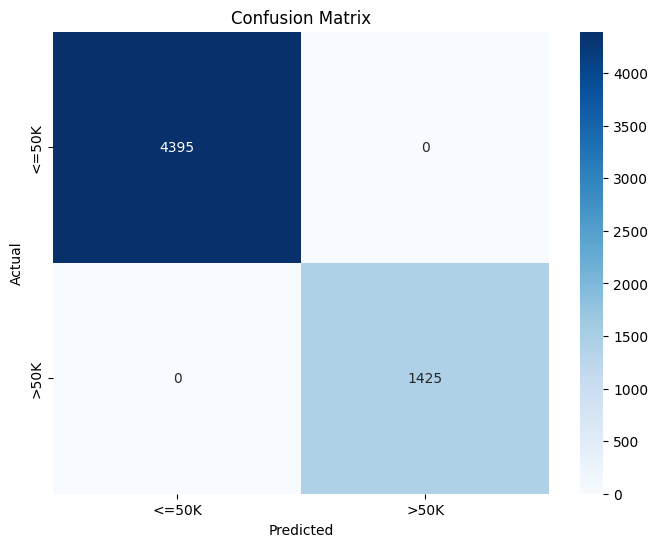

In [36]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### - Feature Importance

In [37]:
# Get the coefficients
coefficients = log_reg.coef_[0] 

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': coefficients
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances.head(10)

,Feature,Importance
12,income_bracket_encoded,12.881923
0,age,0.290316
7,sex,0.221888
8,hours_per_week,0.191579
2,education,0.115009
6,race,0.064029
4,occupation,0.028901
9,native_country,0.005469
11,capital_loss_winsorized,0.000386
10,capital_gain_winsorized,0.000191


### - Visualize Feature Importance

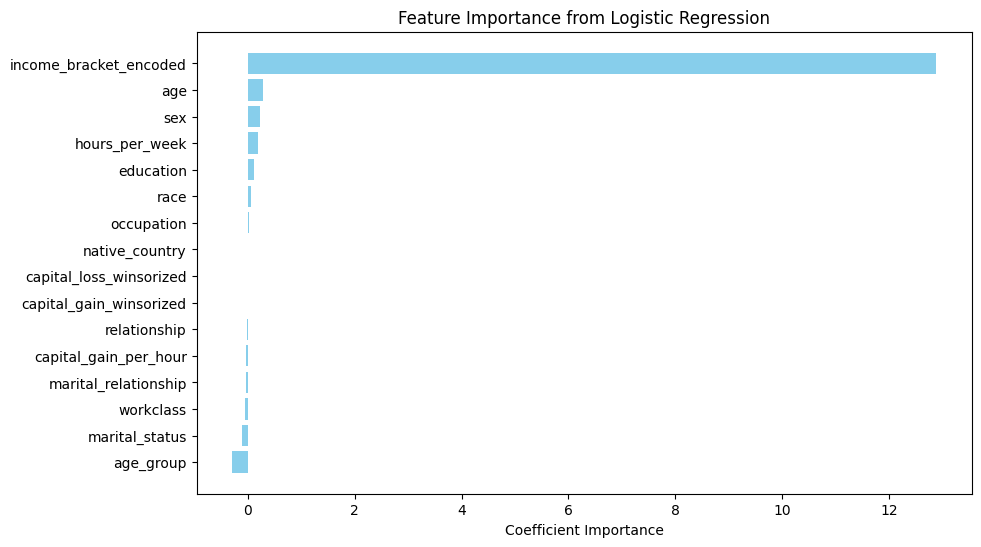

In [38]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Coefficient Importance')
plt.title('Feature Importance from Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

## 2. Random Forest Classifier

**Why??**
- Handles mixed data types (numerical and categorical).
- Automatically manages interactions between features without extensive preprocessing.
- Robust to outliers and irrelevant features.
- Performs well even with imbalanced datasets (with appropriate class weights or sampling).

"Will use it to improve the evaluation"

### **1- Model Initialization:**

In [39]:
# Initializing Random Forest model
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

### **2- Training the Model:**

In [40]:
# Trainning Random Forest model
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### **3- Predictions:**

In [41]:
# Make Predictions
y_pred = random_forest_clf.predict(X_test)

### **4- Evaluation Metrics:**

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4395
           1       1.00      1.00      1.00      1425

    accuracy                           1.00      5820
   macro avg       1.00      1.00      1.00      5820
weighted avg       1.00      1.00      1.00      5820



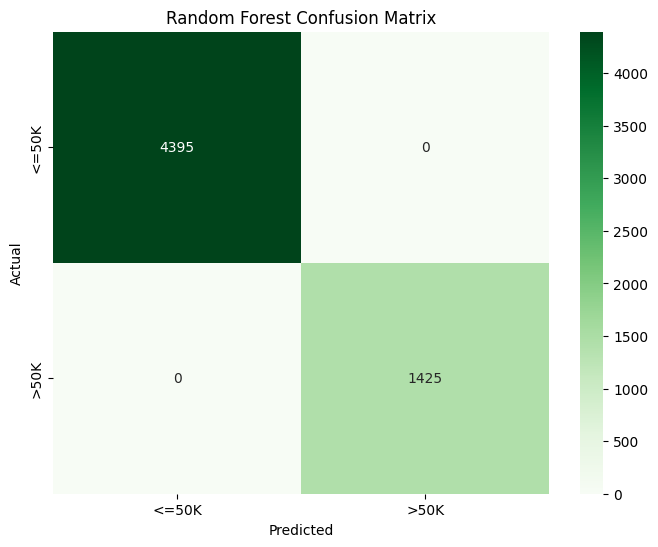

In [42]:
# Evaluate the Model
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

### **5- Feature Importance**

In [43]:
importances = random_forest_clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importance
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importances.head(10)

,Feature,Importance
12,income_bracket_encoded,0.809363
5,relationship,0.055576
10,capital_gain_winsorized,0.047018
14,capital_gain_per_hour,0.020909
3,marital_status,0.018753
15,marital_relationship,0.014729
11,capital_loss_winsorized,0.006198
13,age_group,0.006185
8,hours_per_week,0.006122
2,education,0.005315


### - Visualize Feature Importance

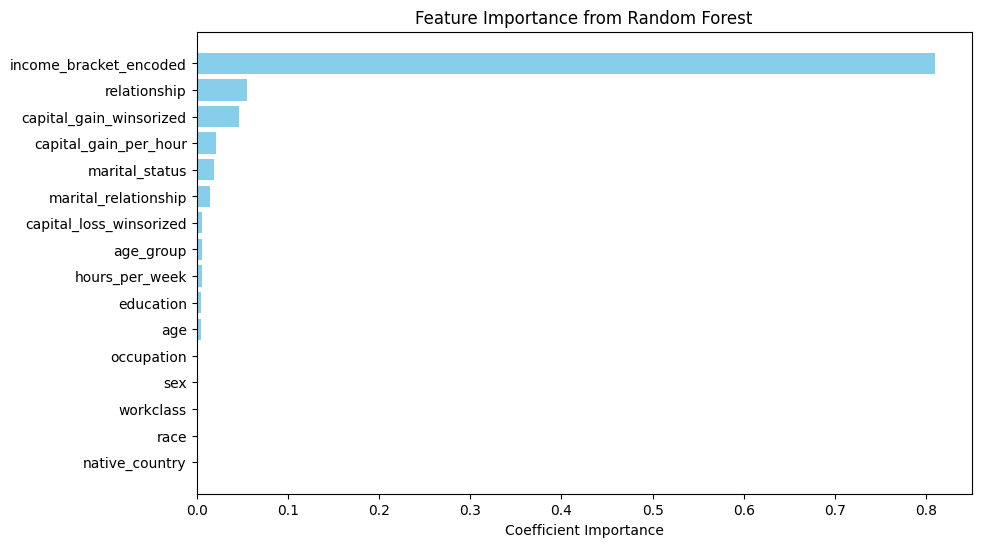

In [44]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Coefficient Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()